# Setting Up Environment

In [1]:
import math, os, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, AlphaDropout
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping

tqdm.pandas()
tf.random.set_seed(42)

%matplotlib inline

print(tf.__version__)

2.4.1


# Data Preparation

In [2]:
raw_data = pd.read_csv('../input/bt4222-project/modelling_dataset.csv')
raw_data = pd.concat([raw_data.pop('Unit Price ($ PSM)'), raw_data], axis=1)

raw_data

,Unit Price ($ PSM),Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
0,6316.0,95.0,1.0,124.3,33,705.752731,1207.822015,87.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13833.0,138.0,1.0,124.3,58,1233.947139,768.529003,88.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,8990.0,99.0,10.0,124.3,50,1039.586179,816.818037,80.0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,6306.0,111.0,6.0,124.3,33,509.516515,501.364218,80.0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,13934.0,122.0,10.0,124.3,58,1253.733260,554.491114,88.0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54669,8229.0,192.0,4.0,153.3,66,526.868822,464.021930,76.0,0,0,...,0,0,0,0,1,0,0,0,0,0
54670,7838.0,111.0,14.0,153.3,66,535.286185,490.669867,80.0,0,0,...,0,0,0,0,1,1,0,0,0,1
54671,13028.0,142.0,14.0,153.3,133,2075.609094,600.145285,72.0,0,0,...,0,0,0,0,0,0,0,1,0,0
54672,13931.0,58.0,6.0,153.3,51,397.651025,539.116552,91.0,0,0,...,0,1,0,0,0,0,0,0,0,0


# Train-Test Split

In [3]:
# Perform 70/30 train_test split
X = raw_data.iloc[:,1:].copy()
y = raw_data.iloc[:,0:1].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=42)
X_train

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
11187,129.0,9.0,139.2,66,313.319878,1514.605671,85.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18593,66.0,13.0,142.3,63,408.305136,1517.388799,84.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27013,61.0,58.0,137.7,85,1529.338980,148.651892,86.0,0,0,0,...,0,1,0,1,0,0,1,1,1,0
39116,105.0,18.0,141.6,66,270.671774,225.750354,86.0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
6042,111.0,37.0,132.6,60,339.216214,258.201238,87.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,107.0,3.0,145.2,36,102.333066,622.895879,73.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
54343,66.0,2.0,153.3,64,414.799433,805.354104,87.0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
38158,74.0,3.0,141.6,142,774.750823,466.130105,76.0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
860,91.0,14.0,124.3,133,658.187930,310.779399,83.0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


# Feature Scaling

In [4]:
def all_transform(X_train, X_test):
    all_features = list(X_train.columns)

    standardScale_vars = ['Area (SQM)',
                          'Floor Number',
                          'PPI',
                          'Average Cases Per Year',
                          'Nearest Primary School',
                          'nearest_station_distance']

    minMax_vars = ['Remaining Lease']

    remaining_features = [x for x in all_features if x not in standardScale_vars and x not in minMax_vars]

    s_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()

    s_scaled = pd.DataFrame(s_scaler.fit_transform(X_train.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_train.index)
    mm_scaled = pd.DataFrame(mm_scaler.fit_transform(X_train.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_train.index)

    X_train = pd.concat([s_scaled, 
                         mm_scaled, 
                         X_train.loc[:, remaining_features].copy()], axis=1)

    s_scaled = pd.DataFrame(s_scaler.transform(X_test.loc[:, standardScale_vars].copy()), columns=standardScale_vars, index=X_test.index)
    mm_scaled = pd.DataFrame(mm_scaler.transform(X_test.loc[:, minMax_vars].copy()), columns=minMax_vars, index=X_test.index)

    X_test = pd.concat([s_scaled, 
                        mm_scaled, 
                        X_test.loc[:, remaining_features].copy()], axis=1)
    
    return X_train, X_test

In [5]:
X_train, X_test = all_transform(X_train, X_test)
X_train

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
11187,0.291530,-0.109176,-0.236229,0.243812,-0.771624,1.226898,0.745098,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18593,-1.125873,0.371998,0.210453,0.125051,-0.570640,1.231468,0.725490,0,1,0,...,0,0,0,0,0,0,0,0,0,0
27013,-1.238366,5.785202,-0.452365,0.995966,1.801408,-1.015899,0.764706,0,0,0,...,0,1,0,1,0,0,1,1,1,0
39116,-0.248433,0.973465,0.109589,0.243812,-0.861865,-0.889309,0.764706,0,0,0,...,0,0,0,0,1,1,0,0,0,0
6042,-0.113442,3.259040,-1.187229,0.006290,-0.716828,-0.836027,0.784314,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44732,-0.203436,-0.830937,0.628316,-0.943799,-1.218061,-0.237225,0.509804,1,0,0,...,0,0,0,0,0,0,1,0,0,0
54343,-1.125873,-0.951230,1.795452,0.164638,-0.556898,0.062359,0.784314,0,0,0,...,0,0,1,0,0,0,1,0,0,0
38158,-0.945886,-0.830937,0.109589,3.252428,0.204740,-0.494623,0.568627,0,0,0,...,0,1,0,0,0,1,0,0,0,0
860,-0.563412,0.492291,-2.383183,2.896144,-0.041901,-0.749697,0.705882,0,0,0,...,0,0,0,1,0,0,0,1,0,0


# Train-Validation Split

In [6]:
# Train-Validation Split
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=42)
X_train

,Area (SQM),Floor Number,PPI,Average Cases Per Year,Nearest Primary School,nearest_station_distance,Remaining Lease,Ang Mo Kio,Bedok,Bishan,...,Yishun,BLUE,BROWN,GREEN,LRT,PURPLE,RED,YELLOW,Apartment,Executive Condominium
9079,-0.338427,-0.830937,-0.510002,-0.072884,-0.337170,-0.184168,0.843137,0,0,0,...,0,0,0,0,0,1,0,1,0,0
50500,0.426521,-0.349763,1.147043,2.896144,-0.084831,-0.944134,0.568627,0,0,0,...,0,0,0,1,0,0,0,1,1,0
42324,-0.068445,1.334345,0.757998,-1.022973,-0.477199,-0.716844,0.882353,0,0,1,...,0,0,0,0,0,0,1,1,0,0
33190,2.496380,0.612585,-1.028729,0.006290,0.510938,0.544301,0.862745,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12391,-0.023448,-0.590350,-0.005684,-0.864625,-0.737739,0.647023,0.803922,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40185,-0.225935,0.371998,0.757998,0.243812,-0.729890,0.154151,0.862745,0,0,0,...,0,0,0,0,0,1,0,0,0,0
46425,0.336527,0.612585,1.319952,0.243812,0.209585,-0.999626,0.725490,0,0,0,...,0,0,0,0,0,1,0,0,0,0
33159,-0.068445,-0.951230,-1.028729,-0.943799,-1.148569,-0.292310,0.549020,1,0,0,...,0,0,0,0,0,0,1,0,0,0
46563,-0.810895,0.492291,1.319952,-0.825038,0.254966,-0.725711,0.882353,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_eval.shape)
print(y_eval.shape)
print(X_test.shape)
print(y_test.shape)

(30616, 52)
(30616, 1)
(7655, 52)
(7655, 1)
(16403, 52)
(16403, 1)


# Baseline Model (Unregularized)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               27136     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
_________________________________________________________________
None 

Epoch 1/500
766/766 [==============================] - 5s 5ms/step - loss: 81914386.4250 - val_loss: 4149

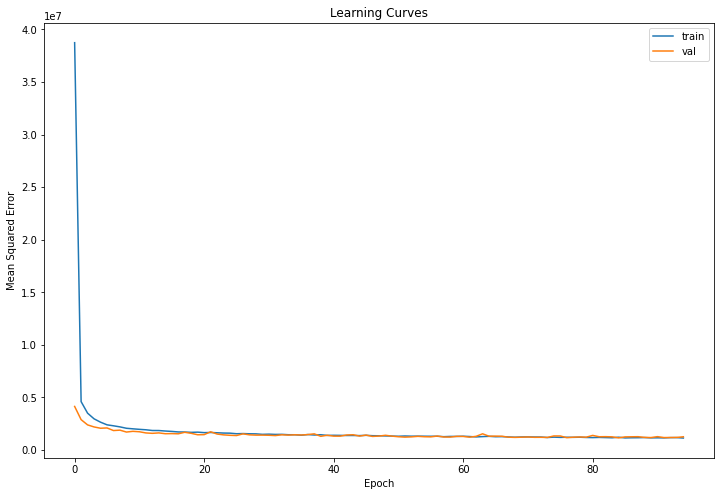

Train RMSE: 1017.033, Train MAPE: 5.699 

Val RMSE: 1108.531, Val MAPE: 6.128 

Test RMSE: 1084.042, Test MAPE: 6.110 

CPU times: user 10min 42s, sys: 1min 10s, total: 11min 53s
Wall time: 5min 28s


<Figure size 864x576 with 0 Axes>

In [8]:
%%time

# Model Parameters
nodes = [512, 512]
batch_norm = True
drop_rate = 0.2

# Model building
n_features = X_train.shape[1]

model = Sequential()
model.add(Dense(nodes[0], activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))

if batch_norm:
    model.add(BatchNormalization())
else:
    model.add(Dropout(drop_rate))

model.add(Dense(nodes[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(drop_rate))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
print(model.summary(), '\n')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stop])

# Model Errors
plt.rcParams['figure.figsize'] = 12,8

plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()

plt.show()
plt.clf()

# Model Evaluation
y_train_pred = model.predict(X_train)
y_eval_pred = model.predict(X_eval)
y_test_pred = model.predict(X_test)

train_rmse = np.sqrt(MeanSquaredError()(y_train, y_train_pred).numpy())
train_mape = MeanAbsolutePercentageError()(y_train, y_train_pred).numpy()

eval_rmse = np.sqrt(MeanSquaredError()(y_eval, y_eval_pred).numpy())
eval_mape = MeanAbsolutePercentageError()(y_eval, y_eval_pred).numpy()

test_rmse = np.sqrt(MeanSquaredError()(y_test, y_test_pred).numpy())
test_mape = MeanAbsolutePercentageError()(y_test, y_test_pred).numpy()

print('Train RMSE: %.3f, Train MAPE: %.3f' % (train_rmse, train_mape), '\n')
print('Val RMSE: %.3f, Val MAPE: %.3f' % (eval_rmse, eval_mape), '\n')
print('Test RMSE: %.3f, Test MAPE: %.3f' % (test_rmse, test_mape), '\n')

# Model Hyperparameter Tuning (Regularization Type + Lambda)

In [9]:
def model_tuning_2nn(reg_type='L2', lambda_val=0.01):

    # Model Parameters
    nodes = [512, 512]
    batch_norm = True
    drop_rate = 0.2

    # Model building
    n_features = X_train.shape[1]
    
    # Selecting regularization type
    if reg_type == 'L1':
        regularizer = tf.keras.regularizers.L1(l1=lambda_val)
    
    elif reg_type == 'L2':
        regularizer = tf.keras.regularizers.L2(l2=lambda_val)

    model = Sequential()
    model.add(Dense(nodes[0], activation='relu', kernel_initializer='he_normal', input_shape=(n_features,), kernel_regularizer=regularizer))

    if batch_norm:
        model.add(BatchNormalization())
    else:
        model.add(Dropout(drop_rate))

    model.add(Dense(nodes[1], activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizer))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')
    print(model.summary(), '\n')

    early_stop = EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stop])

    # Model Errors
    plt.rcParams['figure.figsize'] = 12,8

    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()

    plt.show()
    plt.clf()

    # Model Evaluation
    y_train_pred = model.predict(X_train)
    y_eval_pred = model.predict(X_eval)
    y_test_pred = model.predict(X_test)
    
    train_rmse = np.sqrt(MeanSquaredError()(y_train, y_train_pred).numpy())
    train_mape = MeanAbsolutePercentageError()(y_train, y_train_pred).numpy()
    
    eval_rmse = np.sqrt(MeanSquaredError()(y_eval, y_eval_pred).numpy())
    eval_mape = MeanAbsolutePercentageError()(y_eval, y_eval_pred).numpy()

    test_rmse = np.sqrt(MeanSquaredError()(y_test, y_test_pred).numpy())
    test_mape = MeanAbsolutePercentageError()(y_test, y_test_pred).numpy()

    print('Train RMSE: %.3f, Train MAPE: %.3f' % (train_rmse, train_mape), '\n')
    print('Val RMSE: %.3f, Val MAPE: %.3f' % (eval_rmse, eval_mape), '\n')
    print('Test RMSE: %.3f, Test MAPE: %.3f' % (test_rmse, test_mape), '\n')
    
    return pd.DataFrame([{'regularizer': reg_type,
                         'lambda': lambda_val,
                         'train_rmse': train_rmse,
                         'validation_rmse': eval_rmse,
                         'test_rmse': test_rmse,
                         'train_mape': train_mape,
                         'validation_mape': eval_mape,
                         'test_mape': test_mape}])

# Collecting Error Metrics (for comparison)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               27136     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
_________________________________________________________________
None 

Epoch 1/500
766/766 [==============================] - 4s 5ms/step - loss: 82378125.0065 - val_loss: 41

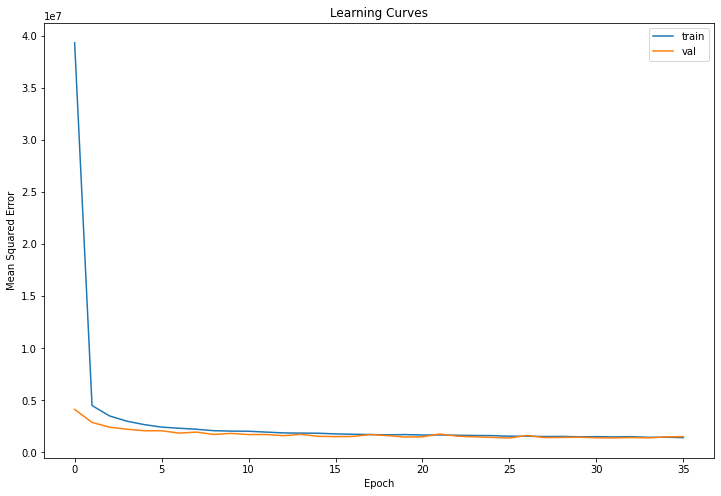

Train RMSE: 1146.178, Train MAPE: 6.452 

Val RMSE: 1199.308, Val MAPE: 6.730 

Test RMSE: 1233.745, Test MAPE: 6.804 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               27136     
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
________________________________________________________

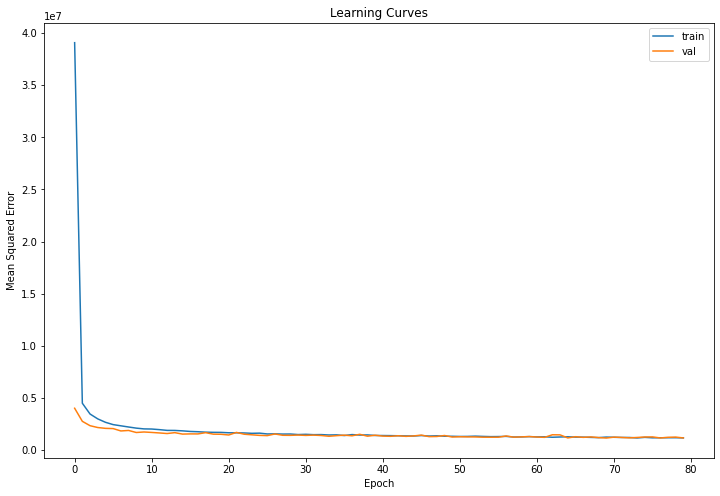

Train RMSE: 974.440, Train MAPE: 5.677 

Val RMSE: 1062.013, Val MAPE: 6.149 

Test RMSE: 1137.227, Test MAPE: 6.194 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               27136     
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
_________________________________________________________

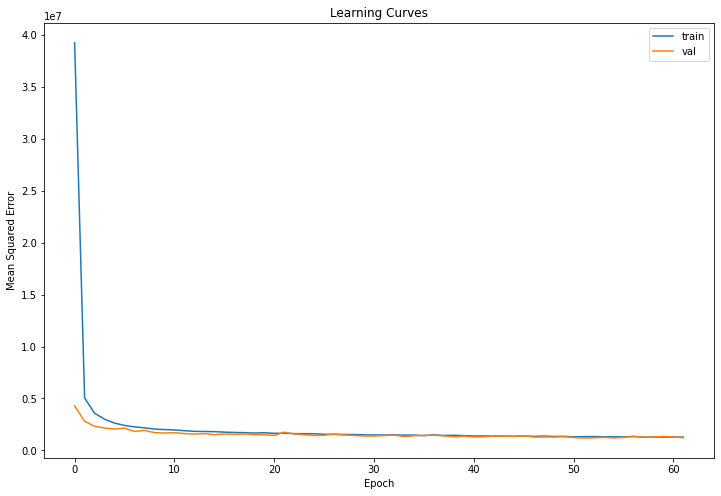

Train RMSE: 1025.308, Train MAPE: 5.888 

Val RMSE: 1092.999, Val MAPE: 6.234 

Test RMSE: 1070.278, Test MAPE: 6.280 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
________________________________________________________

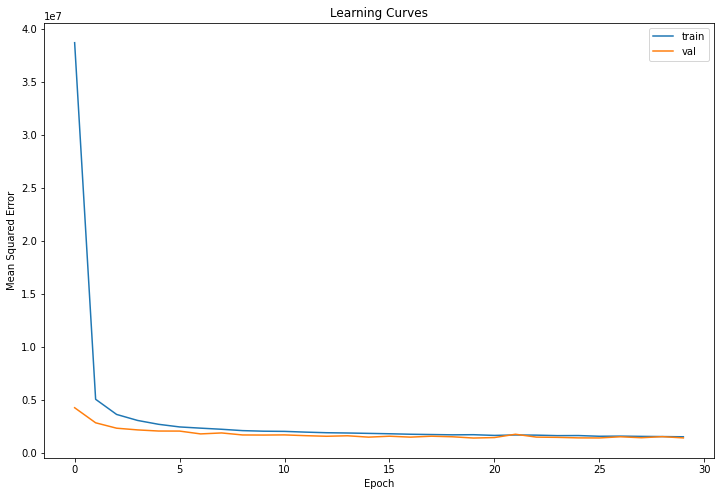

Train RMSE: 1098.499, Train MAPE: 6.304 

Val RMSE: 1144.300, Val MAPE: 6.581 

Test RMSE: 1187.660, Test MAPE: 6.696 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
________________________________________________________

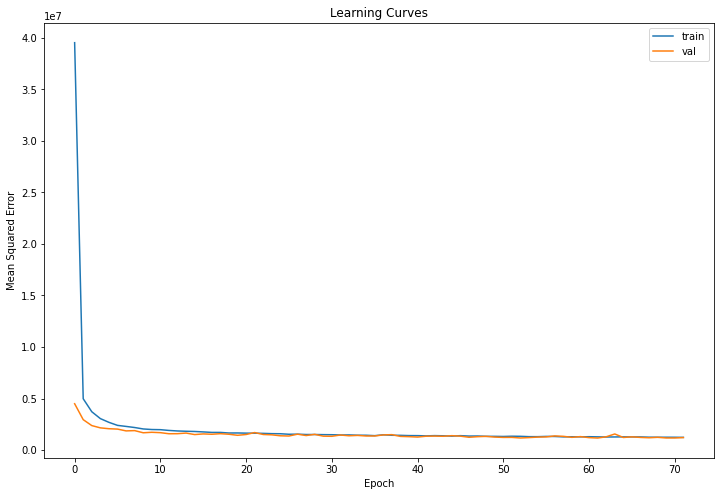

Train RMSE: 1008.933, Train MAPE: 5.958 

Val RMSE: 1062.838, Val MAPE: 6.298 

Test RMSE: 1094.940, Test MAPE: 6.394 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
________________________________________________________

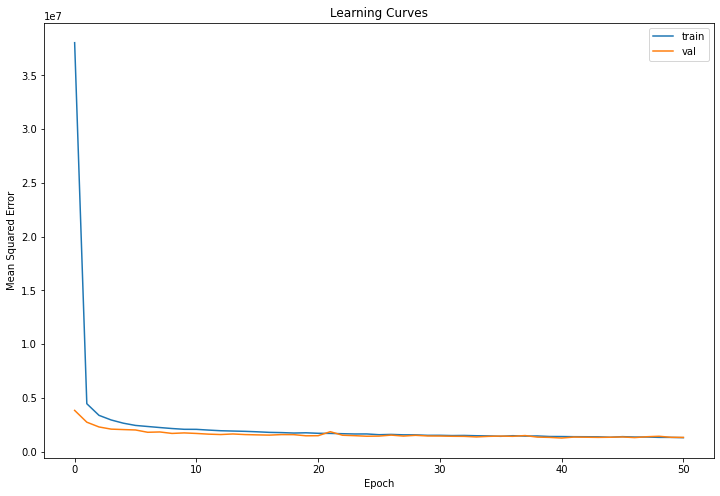

Train RMSE: 1056.084, Train MAPE: 6.115 

Val RMSE: 1099.852, Val MAPE: 6.522 

Test RMSE: 1146.214, Test MAPE: 6.574 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
________________________________________________________

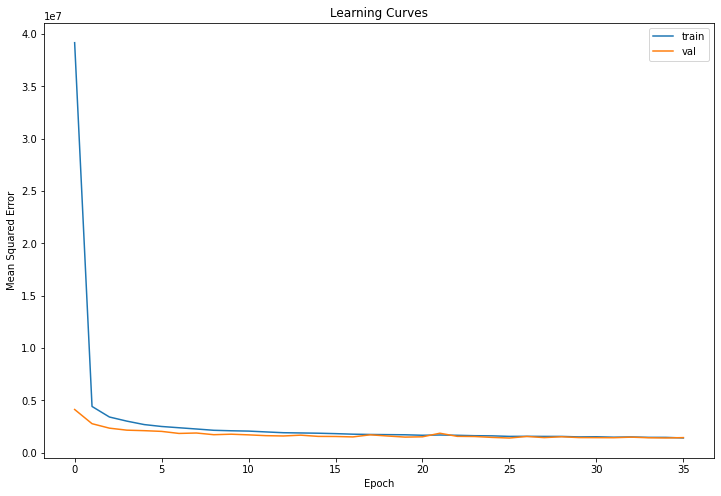

Train RMSE: 1127.898, Train MAPE: 6.368 

Val RMSE: 1163.826, Val MAPE: 6.615 

Test RMSE: 1194.869, Test MAPE: 6.690 

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_8 (Batch (None, 512)               2048      
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
________________________________________________________

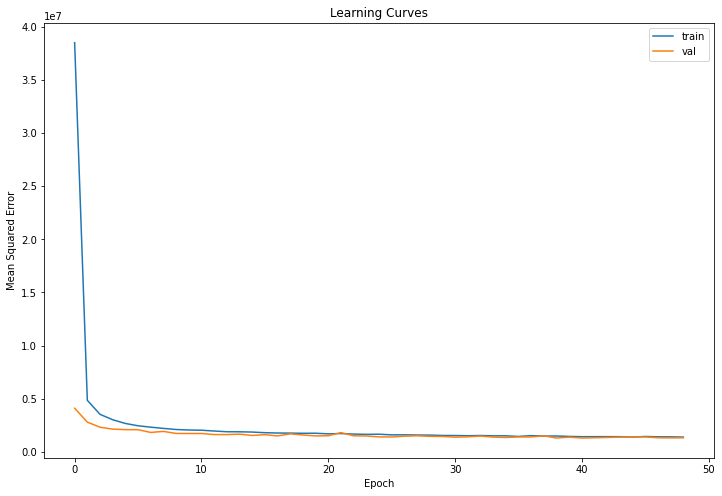

Train RMSE: 1062.990, Train MAPE: 6.312 

Val RMSE: 1112.487, Val MAPE: 6.642 

Test RMSE: 1143.781, Test MAPE: 6.696 

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
________________________________________________________

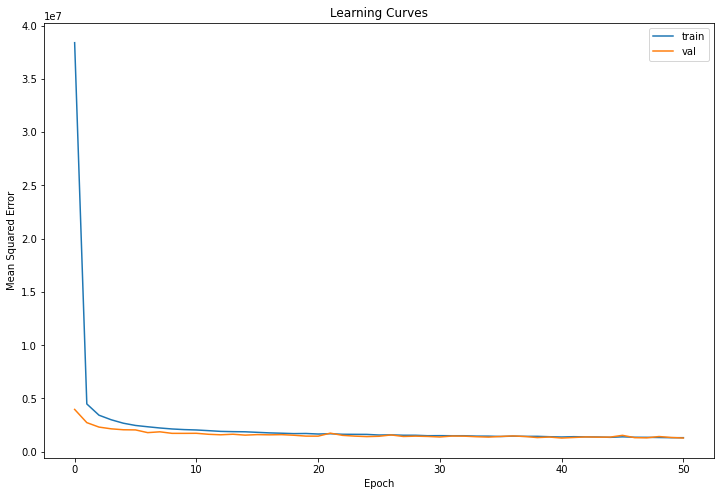

Train RMSE: 1061.091, Train MAPE: 6.093 

Val RMSE: 1111.143, Val MAPE: 6.497 

Test RMSE: 1148.279, Test MAPE: 6.556 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 512)               27136     
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 513       
Total params: 292,353
Trainable params: 291,329
Non-trainable params: 1,024
_______________________________________________________

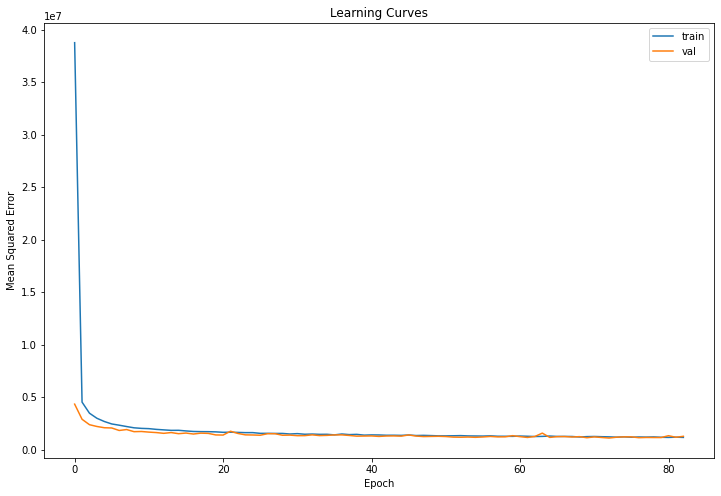

Train RMSE: 1042.230, Train MAPE: 5.859 

Val RMSE: 1091.427, Val MAPE: 6.271 

Test RMSE: 1174.177, Test MAPE: 6.352 

CPU times: user 1h 12min 53s, sys: 7min 28s, total: 1h 20min 21s
Wall time: 33min 53s


,regularizer,lambda,train_rmse,validation_rmse,test_rmse,train_mape,validation_mape,test_mape
0,L1,0.001,1146.178223,1199.307983,1233.745117,6.451579,6.730440,6.804305
1,L1,0.005,974.440002,1062.012573,1137.227295,5.676647,6.149272,6.193791
2,L1,0.010,1025.308472,1092.998535,1070.278442,5.888216,6.233868,6.280467
3,L1,0.050,1098.498901,1144.299805,1187.660156,6.303749,6.580552,6.696383
4,L1,0.100,1008.933411,1062.837769,1094.939697,5.958402,6.297814,6.394494
5,L2,0.001,1056.084351,1099.852417,1146.213989,6.115319,6.522390,6.574051
6,L2,0.005,1127.898438,1163.826050,1194.869385,6.367873,6.615287,6.690328
7,L2,0.010,1062.989502,1112.487061,1143.781128,6.311567,6.641967,6.695835
8,L2,0.050,1061.091309,1111.142822,1148.278564,6.093350,6.496554,6.556295
9,L2,0.100,1042.229736,1091.426880,1174.177002,5.858577,6.271441,6.351535


<Figure size 864x576 with 0 Axes>

In [10]:
%%time
df_results = pd.DataFrame()

for reg in ['L1', 'L2']:
    for lam_val in [0.001, 0.005, 0.01, 0.05, 0.1]:
        output = model_tuning_2nn(reg_type=reg, lambda_val=lam_val)
        df_results = pd.concat([df_results, output], axis=0)
        
df_results.reset_index(drop=True, inplace=True)

df_results

# Saving Results

In [11]:
df_results.to_csv('2nn_regularized.csv', index=False)